In [1]:
import numpy as np
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from copy import copy
import os

emission_dir = "../data/Input_emiss/"
img_dir = "results/img/"
meas_dir = "results/measurement/"

In [2]:
# Original Data consists of 83x45 pixels. This is too large for GPs.
# Therefore we downsample both the transfermatrix and the emmision data
def downsample_2x(mat):
    orig_dtype = mat.dtype
    mat = mat.astype(float)
    mat = (mat[...,1::2,:] + mat[...,:-1:2,:])/2.
    mat = (mat[...,:,1::2] + mat[...,:,:-1:2])/2.
    return mat.astype(orig_dtype)

In [3]:
# Load data
vessel_contour = np.genfromtxt("../data/original/vessel_contour.csv", delimiter=",")
vessel_path = mplPath.Path(vessel_contour)

transfer_line = np.loadtxt("../data/original/transfermatrix_line.txt")
transfer_line = transfer_line.reshape(128,83,45)[:,::-1,:]

transfer_vol = np.swapaxes(np.loadtxt("../data/original/transfermatrix_volume.txt").reshape(128,45,83), 1, 2)
transfer_vol = transfer_vol[:,::-1,:]

radial_coord = np.loadtxt("../data/original/radial_coord.txt")
z_coord = np.loadtxt("../data/original/z_coord.txt")

mask = np.zeros((len(z_coord), len(radial_coord)), dtype=bool)
for i in range(len(z_coord)):
    for j in range(len(radial_coord)):
        mask[i, j] = vessel_path.contains_point((radial_coord[j], z_coord[i]))

mask2 = mask[::-1]
mask2[mask2>0] = 1
mask = downsample_2x(mask2)
print(mask.shape)
np.savetxt("mask.txt", mask)

(42, 23)


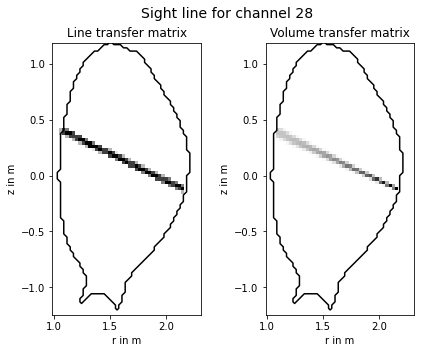

In [7]:
channel = 28
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,5))
fig.suptitle("Sight line for channel 28", fontsize=14)
ax1.set_title("Line transfer matrix")
ax2.set_title("Volume transfer matrix")
ax1.set_xlabel("r in m")
ax1.set_ylabel("z in m")
ax2.set_xlabel("r in m")
ax2.set_ylabel("z in m")
ax2.contour(radial_coord, z_coord, mask2[::-1], levels=[0.5], colors='black')
ax2.imshow(transfer_vol[channel], extent=[radial_coord[0], radial_coord[-1], z_coord[0], z_coord[-1]], cmap=plt.get_cmap("Greys"))
ax1.imshow(transfer_line[channel]*mask2[1:-1,2:], extent=[radial_coord[0], radial_coord[-1], z_coord[0], z_coord[-1]], cmap=plt.get_cmap("Greys"))
ax1.contour(radial_coord, z_coord, mask2[::-1], levels=[0.5], colors='black')
plt.savefig("line_vs_volume", bbox_inches='tight', dpi=250)

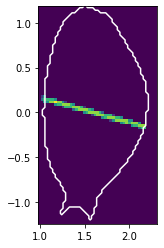

In [29]:
plt.imshow(transfer_line[25]*mask2[1:-1,2:], extent=[radial_coord[0], radial_coord[-1], z_coord[0], z_coord[-1]])
plt.contour(radial_coord, z_coord, mask2, levels=[0.5], colors='white')

In [65]:
emission = np.zeros((85,47))
emission[1:-1,1:-1] = np.genfromtxt(emission_dir + "NN_ 66.txt", 
                                         skip_header = 1).reshape(83, 45)[::-1]
emission = downsample_2x(emission)*mask

(42, 23)


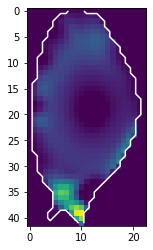

In [66]:
plt.contour(mask, levels=[0.5], colors='white')
plt.imshow(emission)
print(emission.shape)

In [67]:
# This funcion converts the image to the measurementa data by
# multiplying with the transfermatrix.
# The downsampled emission has shape (42, 23) while a downsampling of transfer_mat would result (41,22)
# Therefore we embed the transfermatrix in a larger frame before downsampling it.
def img2meas(img, transfer_mat):
    dim = transfer_mat.shape
    transfer = np.zeros((dim[0],dim[1]+2,dim[2]+2))
    transfer[:,1:-1,1:-1] = 4*transfer_mat # x4 because 4px -> 1px
    transfer = downsample_2x(transfer)
    return np.sum(np.sum((img*transfer), axis=2), axis=1)

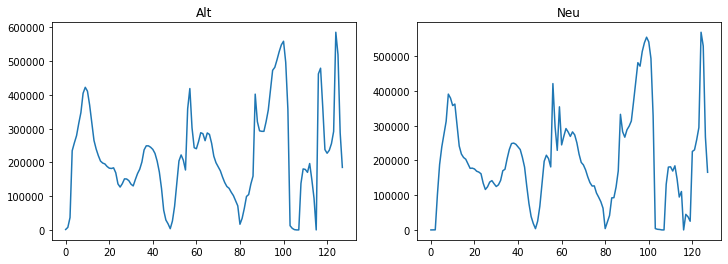

In [68]:
# result for line transfermatrix
res = img2meas(emission, transfer_line)
res2 = img2meas(emission, transfer_vol)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(res)
ax2.plot(res2)
ax1.set_title("Alt")
ax2.set_title("Neu")
plt.savefig("altvsneu.png")

In [69]:
# Iterate over all files in emission_dir and store the results in 
# the img_dir and measurement_dir directory

shots, times = [], []
shot_list_path = "../data/Shot_list_synth_2019-09.txt"
for i, line in enumerate(open(shot_list_path)):
    if "%" in line:
        continue
    shot, _, t = line.split()
    shots.append(int(shot))
    times.append(float(t))


file_list = [file for file in os.listdir(emission_dir) 
             if "NN" in file]

for i, file, in enumerate(file_list):
   
    print(i, file, shots[i], times[i])
    
    emission = np.zeros((85, 47))
    emission[1:-1, 1:-1] = np.genfromtxt(emission_dir + file, 
                                         skip_header = 1).reshape(83, 45)[::-1,:]
    emission = downsample_2x(emission)*mask
    
    measurement_line = img2meas(emission, transfer_line)
    measurement_volume = img2meas(emission, transfer_vol)
    
    np.savetxt(meas_dir + file[:-4] + "_line.txt", measurement_line)
    np.savetxt(meas_dir + file[:-4] + "_volume.txt", measurement_volume)
    
    plt.plot(measurement_line)
    plt.savefig(meas_dir + file[:-4] + "_line.png")
    plt.clf()
    plt.plot(measurement_volume)
    plt.savefig(meas_dir + file[:-4] + "_volume.png")
    plt.clf()
    
    plt.contour(mask, levels=[0.5], colors='white')
    plt.imshow(emission)
    plt.savefig(img_dir + file[:-3] + "png")
    plt.close()
    
    

0 NN_  6.txt 29887 4.4
1 NN_ 13.txt 30506 4.7
2 NN_  9.txt 31253 2.9
3 NN_ 72.txt 31261 2.9
4 NN_ 18.txt 32201 2.9
5 NN_ 67.txt 32304 2.35
6 NN_ 17.txt 32305 3.5
7 NN_ 52.txt 32921 2.0
8 NN_ 59.txt 33032 6.0
9 NN_ 38.txt 33379 4.7
10 NN_ 15.txt 33585 3.0
11 NN_ 65.txt 34238 2.9
12 NN_ 45.txt 34244 2.5
13 NN_ 44.txt 34508 2.8
14 NN_ 51.txt 34508 2.8
15 NN_ 41.txt 34517 3.0
16 NN_ 34.txt 34626 3.0
17 NN_ 48.txt 34796 4.0
18 NN_ 25.txt 34801 5.0
19 NN_ 62.txt 34802 5.0
20 NN_ 57.txt 34825 6.9
21 NN_ 73.txt 35230 2.6
22 NN_ 58.txt 35230 4.5
23 NN_ 64.txt 35245 6.131
24 NN_ 21.txt 35263 2.268
25 NN_ 39.txt 35266 7.125
26 NN_  4.txt 35274 6.55
27 NN_ 31.txt 35275 5.35
28 NN_ 14.txt 35303 1.465
29 NN_ 53.txt 35346 1.475
30 NN_ 50.txt 35471 3.0
31 NN_  7.txt 35496 4.2
32 NN_ 42.txt 35533 1.75
33 NN_ 29.txt 35576 2.8
34 NN_  3.txt 35586 4.5
35 NN_  8.txt 35593 6.4
36 NN_ 43.txt 35595 6.0
37 NN_ 55.txt 35596 6.0
38 NN_ 61.txt 35597 6.0
39 NN_ 12.txt 35598 6.0
40 NN_ 54.txt 35601 6.0
41 NN_ 33.tx

In [70]:
# save reduced transfer matrix to be used by C++ for GP
dim = transfer_line.shape
transferLine = np.zeros((dim[0],dim[1]+2,dim[2]+2))
transferLine[:,1:-1,1:-1] = 4*transfer_line # x4 because 4px -> 1px
transferLine = downsample_2x(transferLine)
np.savetxt("../data/transfermatrix_line_reduced.txt", transferLine.reshape(128, 42*23))

In [71]:
# save reduced transfer matrix to be used by C++ for GP
dim = transfer_vol.shape
transferVol = np.zeros((dim[0],dim[1]+2,dim[2]+2))
transferVol[:,1:-1,1:-1] = 4*transfer_vol # x4 because 4px -> 1px
transferVol = downsample_2x(transferVol)
np.savetxt("../data/transfermatrix_volume_reduced.txt", transferVol.reshape(128, 42*23))